In [1]:
from evaluation_utils import read_global_results, unpivot_baseline_model, unpivot_ssl_model, read_multiple_global_results
from constants import MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL
                    
import pandas as pd
import itertools
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import missingno as msno

In [2]:
data = read_global_results(MODE_2_3_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=data, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_baseline_model(df=data, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

In [10]:
# group by the specified columns and calculate the mean of test_rocauc_ovr
grouped_df = df_ssl.groupby(['SSL_model', 'Encoder', 'Training_scheme'])['test_rocauc_ovr'].mean().reset_index()
new_df = grouped_df[['SSL_model', 'Encoder', 'Training_scheme', 'test_rocauc_ovr']]

# define a function to rank the SSL_model within each group
def rank_models(group):
    group['SSL_rank'] = group['test_rocauc_ovr'].rank(ascending=False, method="min").astype(int)
    return group

ranked_df = new_df.groupby(['Encoder', 'Training_scheme']).apply(rank_models)
# select the desired columns and sort the dataframe
final_df = ranked_df[['Training_scheme', 'Encoder', 'SSL_model', 'SSL_rank', 'test_rocauc_ovr']].sort_values(['Training_scheme', 'Encoder',  'SSL_rank'])

/tmp/ipykernel_19521/2568873837.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ranked_df = new_df.groupby(['Encoder', 'Training_scheme']).apply(rank_models)


In [5]:
df_baseline.groupby("Baseline_model").mean()

,test_rocauc_ovr,Graph_ID
Baseline_model,,
GAT,0.903192,10742.5
GCN,0.904347,10742.5
GIN,0.858026,10742.5


/tmp/ipykernel_19521/3996037511.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS), 6, dtype=int)])


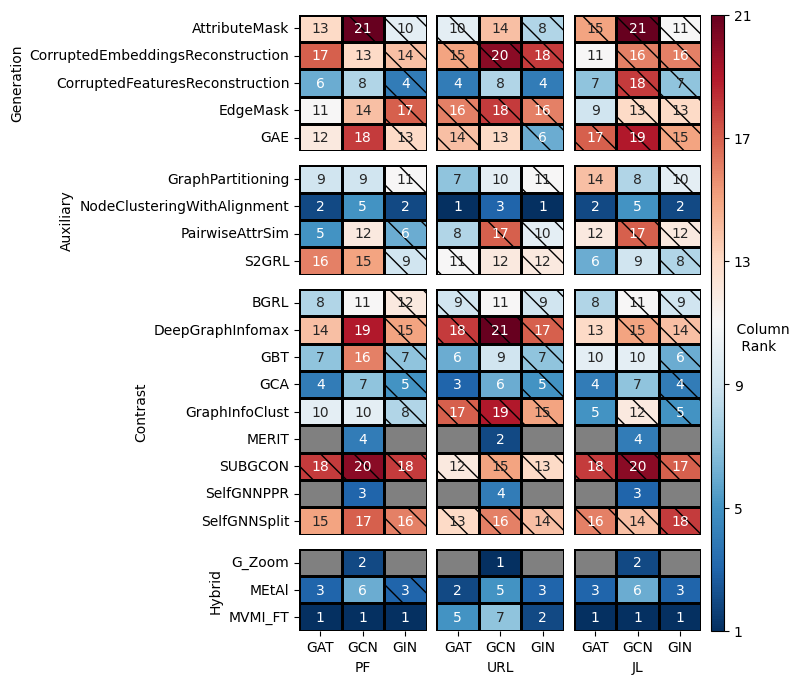

In [20]:
# Plotting ranks per TS/Encoder sceme

fig=plt.figure(figsize=(5,8))
all_categories = [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]
height_ratios = [len(category) / len(SSL_MODELS) for category in all_categories]
gs = gridspec.GridSpec(4, 4, width_ratios=[1,1,1,0.1], height_ratios=height_ratios)
gs.update(left=0.1, right=0.95, wspace=0.1, hspace=0.1)

for i, (category, category_name) in enumerate(zip(all_categories, ["Generation", "Auxiliary", "Contrast", "Hybrid"])):
    category_df = final_df[final_df["SSL_model"].isin(category)]
    for j, ts in enumerate(TRAINING_SCHEMES):
        ax=plt.subplot(gs[i,j]) 
        ts_df = category_df[category_df["Training_scheme"] == ts]
        plotting_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values='SSL_rank')
        g = sns.heatmap(plotting_df, cmap='RdBu_r', cbar=False, annot=True, 
                    linewidths=1, vmin = 1, vmax=len(SSL_MODELS), linecolor="black")
        g.set_facecolor("grey")

        hatch_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values=TEST_METRIC)
        #mask = np.ma.masked_equal(hatch_df.applymap(lambda x: x.mid if pd.notnull(x) else 0).values, bin.mid)
        ax.pcolor(np.arange(len(plotting_df.columns)+1), np.arange(len(plotting_df.index)+1), 
                  np.where((hatch_df.values < 0.904347), hatch_df.values, np.nan), hatch="\\", alpha=0.)


        if j != 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel(category_name)
        if i != 3:
            ax.set_xlabel("")
            ax.set_xticks([])
        else:
            ax.set_xlabel(ts)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)



ax_bar=plt.subplot(gs[:,3]  )
cbar = mpl.colorbar.ColorbarBase(ax_bar, cmap="RdBu_r")
cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS), 6, dtype=int)])
cbar.set_label("    Column \n Rank", rotation=0)


In [27]:
plotting_df

Encoder,GAT,GCN,GIN
SSL_model,,,
G_Zoom,NaN,10.0,NaN
MEtAl,24.0,53.0,57.0
MVMI_FT,4.0,8.0,18.0


In [31]:
ts_df

,SSL_model,Encoder,Training_scheme,test_rocauc_ovr,SSL_rank
81,G_Zoom,GCN,JL,0.945317,10
105,MEtAl,GAT,JL,0.935140,24
108,MEtAl,GCN,JL,0.913740,53
111,MEtAl,GIN,JL,0.912769,57
114,MVMI_FT,GAT,JL,0.951984,4
117,MVMI_FT,GCN,JL,0.948457,8
120,MVMI_FT,GIN,JL,0.939907,18


In [35]:
plotting_df

Encoder,GAT,GCN,GIN
SSL_model,,,
AttributeMask,93,115,144
CorruptedEmbeddingsReconstruction,67,101,161
CorruptedFeaturesReconstruction,54,105,131
EdgeMask,62,96,149
GAE,107,108,160


/tmp/ipykernel_19521/1894534040.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS)*3*3 - 12, 6, dtype=int)])


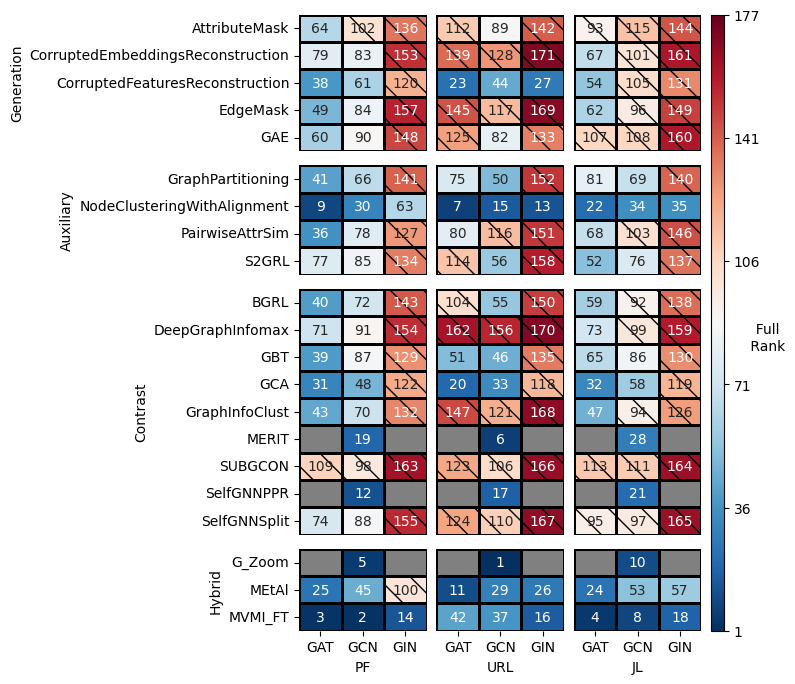

In [38]:
# Plotting global ranks (n~170)
ranked_df2 = new_df.copy()
ranked_df2['SSL_rank'] = ranked_df2['test_rocauc_ovr'].rank(ascending=False, method="min").astype(int)

# Plotting ranks per TS/Encoder sceme

fig=plt.figure(figsize=(5,8))
all_categories = [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]
height_ratios = [len(category) / len(SSL_MODELS) for category in all_categories]
gs = gridspec.GridSpec(4, 4, width_ratios=[1,1,1,0.1], height_ratios=height_ratios)
gs.update(left=0.1, right=0.95, wspace=0.1, hspace=0.1)

for i, (category, category_name) in enumerate(zip(all_categories, ["Generation", "Auxiliary", "Contrast", "Hybrid"])):
    category_df = ranked_df2[ranked_df2["SSL_model"].isin(category)]
    for j, ts in enumerate(TRAINING_SCHEMES):
        ax=plt.subplot(gs[i,j]) 
        ts_df = category_df[category_df["Training_scheme"] == ts]
        plotting_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values='SSL_rank')
        g = sns.heatmap(plotting_df, cmap='RdBu_r', cbar=False, annot=True, fmt='.0f',
                    linewidths=1, vmin = 1, vmax=len(SSL_MODELS)*3*3 - 12, linecolor="black")
        g.set_facecolor("grey")

        hatch_df = ts_df.pivot(index=['SSL_model'], columns=['Encoder'], values=TEST_METRIC)
        ax.pcolor(np.arange(len(plotting_df.columns)+1), np.arange(len(plotting_df.index)+1), 
                  np.where((hatch_df.values < 0.904347), hatch_df.values, np.nan), hatch="\\", alpha=0.)


        if j != 0:
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_ylabel(category_name)
        if i != 3:
            ax.set_xlabel("")
            ax.set_xticks([])
        else:
            ax.set_xlabel(ts)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)



ax_bar=plt.subplot(gs[:,3]  )
cbar = mpl.colorbar.ColorbarBase(ax_bar, cmap="RdBu_r")
cbar.set_ticklabels([str(t) for t in np.linspace(1, len(SSL_MODELS)*3*3 - 12, 6, dtype=int)])
cbar.set_label("  Full \n Rank", rotation=0)

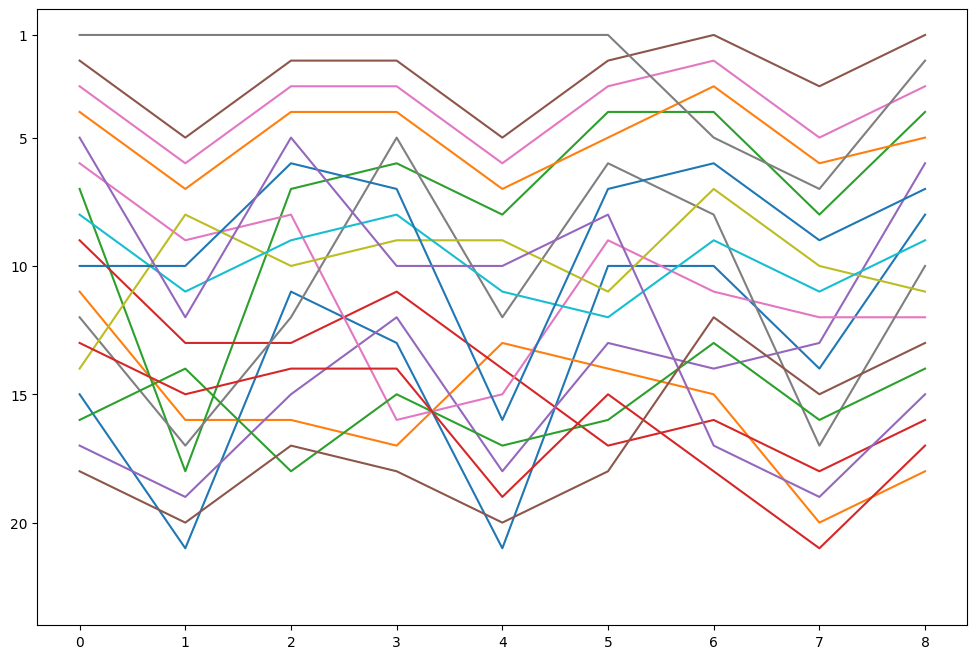

In [70]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

for method, ranks in rank_lines.items():
    plt.plot(range(len(ranks)), ranks, label=method)


# plt.ylim(0.88, 1.0)
plt.ylim(24,0)
plt.yticks([20, 15, 10, 5, 1])
# show the plot
plt.show()

In [80]:
data

array([[0.23271265, 0.96014878, 0.21764037],
       [0.20102259, 0.7841852 , 0.79876152],
       [0.24587112, 0.85166163, 0.59354969]])

In [57]:
df_baseline

,test_rocauc_ovr,Baseline_model,Graph_ID,Experiment
0,0.953306,GCN,0,Mode 1
1,0.945873,GCN,1,Mode 1
2,0.857083,GCN,2,Mode 1
3,0.853678,GCN,3,Mode 1
4,0.650312,GCN,4,Mode 1
...,...,...,...,...
358282,0.819011,GIN,119424,Mode 2/3
358283,0.898181,GIN,119425,Mode 2/3
358284,0.942738,GIN,119426,Mode 2/3
358285,0.684476,GIN,119427,Mode 2/3


/tmp/ipykernel_48654/1071568612.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for mode, group in df_baseline.groupby(['Experiment']):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


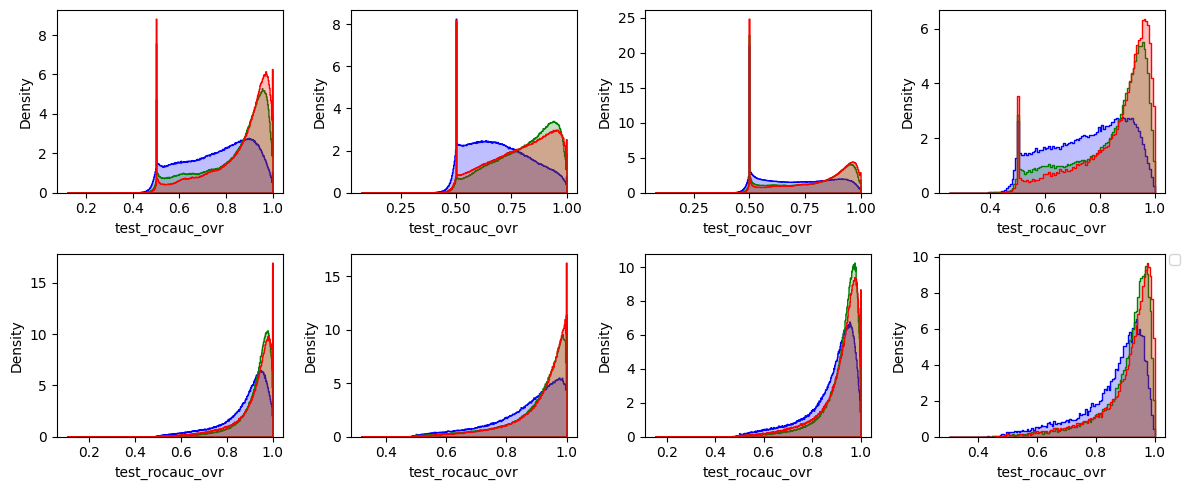

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))

groups = defaultdict(lambda: defaultdict(lambda: defaultdict()))
for (mode, ts), group in df_ssl.groupby(['Experiment', 'Training_scheme']):
    groups[mode][ts] = group
for i, mode in enumerate(groups.keys()):
    for j, ts in enumerate(TRAINING_SCHEMES):
        sns.histplot(data=groups[mode][ts], x=TEST_METRIC, hue="Encoder", ax = axes[i][j], 
                     palette=ENCODER_COLORS, stat="density", element="step", common_norm=False, legend=False)

groups_base = defaultdict()
for mode, group in df_baseline.groupby(['Experiment']):
    groups_base[mode] = group
for i, mode in enumerate(groups_base.keys()):
    sns.histplot(data=groups_base[mode], x=TEST_METRIC, hue="Baseline_model", ax = axes[i][3], 
                 palette=ENCODER_COLORS, stat="density", element="step", common_norm=False, legend=False)

# Final plotting details 
fig.tight_layout()
plt.show()

